In [13]:
%matplotlib inline
# imports required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pynetlogo
import numpy as np
import sys
sys.path.append('../')

from LandLab_experiments.ecohydr_mod import EcoHyd

In [14]:
def get_yearly_temp(csv_path, num_years):
    df = pd.read_csv(csv_path)
    df.dt = pd.to_datetime(df.dt)
    avg_temp_per_year = []
    max_temp_per_year = []
    min_temp_per_year = []
    for year in range(0, num_years):
        earliest_yr = df.iloc[0, 0].year
        year = year + earliest_yr
        if len(df.loc[(df.dt.dt.year == year), :]) > 365:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].iloc[:-1].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].iloc[:-1].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].iloc[:-1].tolist())
        else:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].tolist())
    
    return avg_temp_per_year, max_temp_per_year, min_temp_per_year

yearData = get_yearly_temp("/Users/mabelwylie/Documents/NetLogo-MOSS-Python/CouplingRepo/TreesAndThat/LandLab_experiments/new_temp_data.csv", 10)

In [15]:
def setUpNetLogoModel(leadFarmers, desperation, jealousy, grace):
    # think this is for the GUI idk?
    sns.set_style("white")
    sns.set_context("talk")

    # starts a NetLogo link, point the netlogo home path to where you have it installed on your machine
    netlogo = pynetlogo.NetLogoLink(
        gui=False,
        netlogo_home="/Volumes/NetLogo 6.3.0/NetLogo 6.3.0"
    )

    # loads a .nlogo model from provided path
    netlogo.load_model("/Users/mabelwylie/Documents/NetLogo-MOSS-Python/CouplingRepo/TreesAndThat/Coupling/modelv2.nlogo")

     # sets globals
    globals = "update-globals " + str(leadFarmers) + " " + str(desperation) + " " + str(jealousy) + " " + str(grace)
    #netlogo.command(globals)
    
    # runs the model setup command
    netlogo.command("setup")

    return netlogo

In [16]:
def reportsToDataFrame(netlogo):
    # gets field attributes and puts it in a data frame
    fieldAttributes = netlogo.report("get-info")
    sorted_list = sorted(fieldAttributes, key=lambda x: (-x[1],x[0]))
    fieldData = pd.DataFrame(columns=["who", "xcor","ycor","owner-id","implements-WSA", "yield"], data=sorted_list)
    return fieldData

In [17]:
def convertWSAToNPArray(data):
    # sets bool into correct format to pass to hydrology model
    emptynp = np.empty((51,51))
    for i in range(0,51):
        for j in range(0,51):
            ycorFromIndex = i * -1 + 25
            xcorFromIndex = j - 25
            emptynp[i][j]= data.loc[(data['ycor'] == ycorFromIndex) & (data['xcor'] == xcorFromIndex)]["implements-WSA"].iloc[0]
    return emptynp

In [26]:
def convertHydrologyToDF(hydrologyArray, data):
    # method converts the hydrology model output into a pandas dataframer
    flattenedArray = hydrologyArray.flatten()
    # 2 is the placeholder to multiply the biomass to get yield
    data["yield"] = flattenedArray
    return data

In [19]:
def fullModelRun(leadFarmers, desperation, jealousy, grace, fileSuffix, input_csv_path, from_year, to_year):
    # sets up model
    netlogo = setUpNetLogoModel(leadFarmers, desperation, jealousy, grace)

    # gets base field attributes and puts it in a data frame
    fieldData = reportsToDataFrame(netlogo)

    # make dataframe to record all changes
    bestData = fieldData.copy()
    
    #get input temperature data
    avg, maxi, mini = get_yearly_temp(input_csv_path, from_year, to_year)

    for year in range(0,10):
        # run for 10 years

        avg_yr, maxi_yr, mini_yr = avg[year], maxi[year], mini[year]

        # runs one step of social model
        netlogo.command("farming-year")
        print("farming command")

        # converts field data to a df
        fieldData = reportsToDataFrame(netlogo)
        print("convertedtoDF")

        # converts the usingWSA bool for each field into an NP array
        hydrologyInput = convertWSAToNPArray(fieldData)
        print("converted to NP array")

        # use dummy model
        hydrologyOutput = hydrologyModelYear(hydrologyInput, avg_yr, maxi_yr, mini_yr)
        
        # trying to implement the hydrology model
        # input to this block will be the WSA np.array, with 0 or 1 corresponding to if the field is using WSA
        # the output of this block should be a np.array with biomass
        
        #Ecohyd_model = EcoHyd(WSA_array=hydrologyInput)
        #EcoHyd.stepper(Ecohyd_model)

        # converts the updated yields to the dataframe
        convertHydrologyToDF(hydrologyOutput,fieldData)
        print("Converted output to df")

        # writes this new yield information to the netlogo implementation
        netlogo.write_NetLogo_attriblist(fieldData, "field")
        print("wrote to netlogo")

        

## dummy hydrology model to test running
def hydrologyModelYear(input):
    print("One year yield")
    return np.zeros((51,51))

fullModelRun(20, 0.5, 0.5, 3, 1)

TypeError: fullModelRun() missing 3 required positional arguments: 'input_csv_path', 'from_year', and 'to_year'

converted to NP array
0
0
soil moisture sat.: [ 0.63179365  0.63177504  0.63175719 ...,  0.64515638  0.64517006
  0.64518428]
live biomass:  [ 101.0237153   101.02379319  101.02386784 ...,  100.96451858  100.9644544
  100.96438768]
ET:  [ 10.80885199  10.81284477  10.8166718  ...,   7.89596039   7.8929277
   7.88977495]
ET30:  [ 10.80885199  10.81284477  10.8166718  ...,   7.89596039   7.8929277
   7.88977495]
PFT:  [0 0 0 ..., 0 0 0]
0
0
soil moisture sat.: [ 0.56456472  0.56452898  0.56449472 ...,  0.58989617  0.58992174
  0.58994832]
live biomass:  [ 100.03966783  100.03981922  100.03996431 ...,   99.92474959   99.92462515
   99.92449577]
ET:  [ 10.80885199  10.81284477  10.8166718  ...,   7.89596039   7.8929277
   7.88977495]
ET30:  [ 10.80885199  10.81284477  10.8166718  ...,   7.89596039   7.8929277
   7.88977495]
PFT:  [0 0 0 ..., 0 0 0]
1
0.0027397260273972603
soil moisture sat.: [ 0.41007545  0.40997813  0.40988485 ...,  0.47945758  0.47952775
  0.47960069]
live biomass:  [ 0.

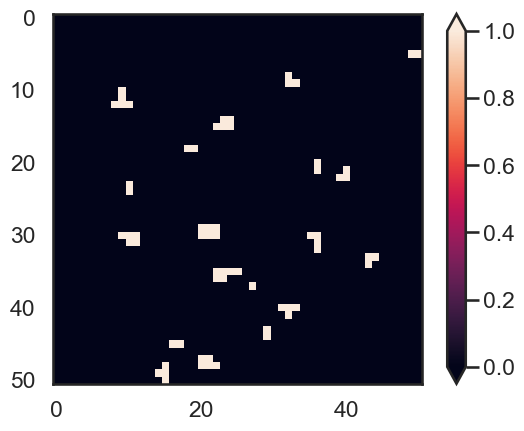

In [27]:
def fullModelRun1(leadFarmers, desperation, jealousy, grace, fileSuffix):
    # sets up model
    netlogo = setUpNetLogoModel(leadFarmers, desperation, jealousy, grace)
    WSA_array = np.zeros((51,51))
    # Set 20 random values to 1
    #indices_to_set = np.random.choice(range(51 * 51), size=20, replace=False)
    #row_indices, col_indices = np.unravel_index(indices_to_set, (51, 51))
    #WSA_array[row_indices, col_indices] = int(1)
    Ecohyd_model = EcoHyd()

    # gets base field attributes and puts it in a data frame
    fieldData = reportsToDataFrame(netlogo)
    #fieldData['Year'] = -1
    
    for year in range(0,1):
        # run for 10 years

        # converts the usingWSA bool for each field into an NP array
        hydrologyInput = convertWSAToNPArray(fieldData)
        print("converted to NP array")

        # use dummy model
        # hydrologyOutput = hydrologyModelYear(hydrologyInput)

        biomass_harvest, SM_canic_end = Ecohyd_model.stepper(hydrologyInput)
        
        # trying to implement the hydrology model
        # input to this block will be the WSA np.array, with 0 or 1 corresponding to if the field is using WSA
        # the output of this block should be a np.array with biomass
        
        #Ecohyd_model = EcoHyd(WSA_array=hydrologyInput)
        #EcoHyd.stepper(Ecohyd_model)
        print(biomass_harvest)
        # converts the updated yields to the dataframe
        savethis = convertHydrologyToDF(biomass_harvest,fieldData)
        print(savethis)
        print("Converted output to df")

        # writes this new yield information to the netlogo implementation
        netlogo.write_NetLogo_attriblist(fieldData, "field")
        print("wrote to netlogo")

        # runs one step of social model
        netlogo.command("farming-year")
        print("farming command")

        # converts field data to a df
        fieldDataTemp = reportsToDataFrame(netlogo)
        print("convertedtoDF")

        plt.imshow(np.reshape(hydrologyInput, (51,51)))
        plt.colorbar(extend = 'both')
        return savethis, fieldData, fieldDataTemp

        

## dummy hydrology model to test running
def hydrologyModelYear(input):
    print("One year yield")
    return np.zeros((51,51))

savethis, fieldD, fieldDT = fullModelRun1(20, 0.5, 0.5, 3, 1)

In [21]:
fieldD

,who,xcor,ycor,owner-id,implements-WSA,yield
0,802.0,25.0,-23.0,21.0,0.0,200.079336
1,833.0,25.0,-10.0,627.0,0.0,200.079638
2,950.0,25.0,19.0,219.0,0.0,200.079929
3,1014.0,25.0,25.0,163.0,0.0,200.080206
4,1044.0,25.0,5.0,121.0,0.0,200.080471
...,...,...,...,...,...,...
2596,3100.0,-25.0,-16.0,793.0,0.0,199.849967
2597,3157.0,-25.0,-2.0,365.0,0.0,199.849738
2598,3187.0,-25.0,-20.0,774.0,0.0,199.849499
2599,3233.0,-25.0,-11.0,110.0,0.0,199.849250


In [22]:
fieldDT

,who,xcor,ycor,owner-id,implements-WSA,yield
0,802.0,25.0,-23.0,21.0,0.0,200.079336
1,833.0,25.0,-10.0,627.0,0.0,200.079638
2,950.0,25.0,19.0,219.0,0.0,200.079929
3,1014.0,25.0,25.0,163.0,0.0,200.080206
4,1044.0,25.0,5.0,121.0,0.0,200.080471
...,...,...,...,...,...,...
2596,3100.0,-25.0,-16.0,793.0,0.0,199.849967
2597,3157.0,-25.0,-2.0,365.0,0.0,199.849738
2598,3187.0,-25.0,-20.0,774.0,0.0,199.849499
2599,3233.0,-25.0,-11.0,110.0,0.0,199.849250


In [28]:
savethis

,who,xcor,ycor,owner-id,implements-WSA,yield
0,827.0,25.0,-10.0,456.0,0.0,100.039668
1,847.0,25.0,-9.0,694.0,0.0,100.039819
2,911.0,25.0,4.0,547.0,0.0,100.039964
3,927.0,25.0,-13.0,495.0,0.0,100.040103
4,943.0,25.0,-22.0,783.0,0.0,100.040236
...,...,...,...,...,...,...
2596,3286.0,-25.0,-11.0,288.0,0.0,99.924984
2597,3289.0,-25.0,3.0,294.0,0.0,99.924869
2598,3313.0,-25.0,-6.0,714.0,0.0,99.924750
2599,3320.0,-25.0,-9.0,144.0,0.0,99.924625


In [8]:
netlogo = setUpNetLogoModel(20, 0.1, 0.2, 3)
df = reportsToDataFrame(netlogo)
df.loc[df["implements-WSA"] == 1]

,who,xcor,ycor,owner-id,implements-WSA,yield
